<a href="https://colab.research.google.com/github/ChristineDewi/Blinks-Detection/blob/main/YOLO_NAS_V8_M_FRUITS15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install super-gradients==3.1.3
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import models

yolo_nas_m = models.get("yolo_nas_m", pretrained_weights="coco")

The console stream is logged into /root/sg_logs/console.log


[2023-09-19 07:46:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-09-19 07:46:23] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-19 07:46:27] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-19 07:46:27] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-19 07:46:27] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-19 07:46:27] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-09-19 07:46:28] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md


In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_m,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_M (YoloNAS_M)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

In [ ]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'Checkpoints-Run-M'
trainer = Trainer(experiment_name='Fruits-15 Image Dataset-M', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gryikRGomZcKYLhJEjHv")
project = rf.workspace("anderton-tuhuleruw-86tmi").project("fruits-15-3kwug")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.134`, to intall it `pip install ultralytics==8.0.134`.


Extracting Dataset Version Zip to Fruits-15-1 in yolov8::   0%|          | 0/5840 [00:00<?, ?it/s]

Extracting Dataset Version Zip to Fruits-15-1 in yolov8:: 100%|██████████| 5840/5840 [00:01<00:00, 3855.80it/s]


In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [ ]:
dataset_params = {
    'data_dir':'/content/Fruits-15-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes':  [' Apple B','Apple G1','Apricot','Avocado','Banana','Cherry','Grape','Kiwi','Mango','Orange','Papaya','Peach','Pineapple','Pomegranate','Strawberry']
}

In [ ]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.plot()

NameError: ignored

In [ ]:
from super_gradients.training import models
model = models.get('yolo_nas_m',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-09-19 07:49:16] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [ ]:
  from super_gradients.training.losses import PPYoloELoss
  from super_gradients.training.metrics import DetectionMetrics_050
  from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

  train_params = {
      # ENABLING SILENT MODE
      'silent_mode': True,
      "average_best_models":True,
      "warmup_mode": "linear_epoch_step",
      "warmup_initial_lr": 1e-6,
      "lr_warmup_epochs": 3,
      "initial_lr": 5e-4,
      "lr_mode": "cosine",
      "cosine_final_lr_ratio": 0.1,
      "optimizer": "Adam",
      "optimizer_params": {"weight_decay": 0.0001},
      "zero_weight_decay_on_bias_and_bn": True,
      "ema": True,
      "ema_params": {"decay": 0.9, "decay_type": "threshold"},
      # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
      "max_epochs": 100,
      "mixed_precision": True,
      "loss": PPYoloELoss(
          use_static_assigner=False,
          # NOTE: num_classes needs to be defined here
          num_classes=len(dataset_params['classes']),
          reg_max=16
      ),
      "valid_metrics_list": [
          DetectionMetrics_050(
              score_thres=0.1,
              top_k_predictions=300,
              # NOTE: num_classes needs to be defined here
              num_cls=len(dataset_params['classes']),
              normalize_targets=True,
              post_prediction_callback=PPYoloEPostPredictionCallback(
                  score_threshold=0.01,
                  nms_top_k=1000,
                  max_predictions=300,
                  nms_threshold=0.7
              )
          )
      ],
      "metric_to_watch": 'mAP@0.50'
  }

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to Checkpoints-Run-M/Fruits-15 Image Dataset-M/console_Sep19_07_49_22.txt


[2023-09-19 07:49:22] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.


AssertionError: ignored

In [ ]:
best_model = models.get('yolo_nas_m',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/Checkpoints-Run-M/Fruits-15 Image Dataset-M/average_model.pth")

[2023-09-18 23:35:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/Checkpoints-Run-M/Fruits-15 Image Dataset-M/average_model.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 19/19 [00:12<00:00,  1.93it/s]

{'PPYoloELoss/loss_cls': 1.4806125,
 'PPYoloELoss/loss_iou': 0.13149601,
 'PPYoloELoss/loss_dfl': 1.2532904,
 'PPYoloELoss/loss': 2.4359977,
 'Precision@0.50': 0.01721499115228653,
 'Recall@0.50': 0.9421430826187134,
 'mAP@0.50': 0.24607178568840027,
 'F1@0.50': 0.0337548591196537}

Testing: 100%|██████████| 19/19 [00:12<00:00,  1.50it/s]


Visualize inference results

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=False
)

In [ ]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2023-09-18 23:38:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-18 23:38:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-18 23:38:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-18 23:38:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-18 23:39:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-18 23:39:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-18 23:39:05] INFO -

In [ ]:
import random
random.seed(5)

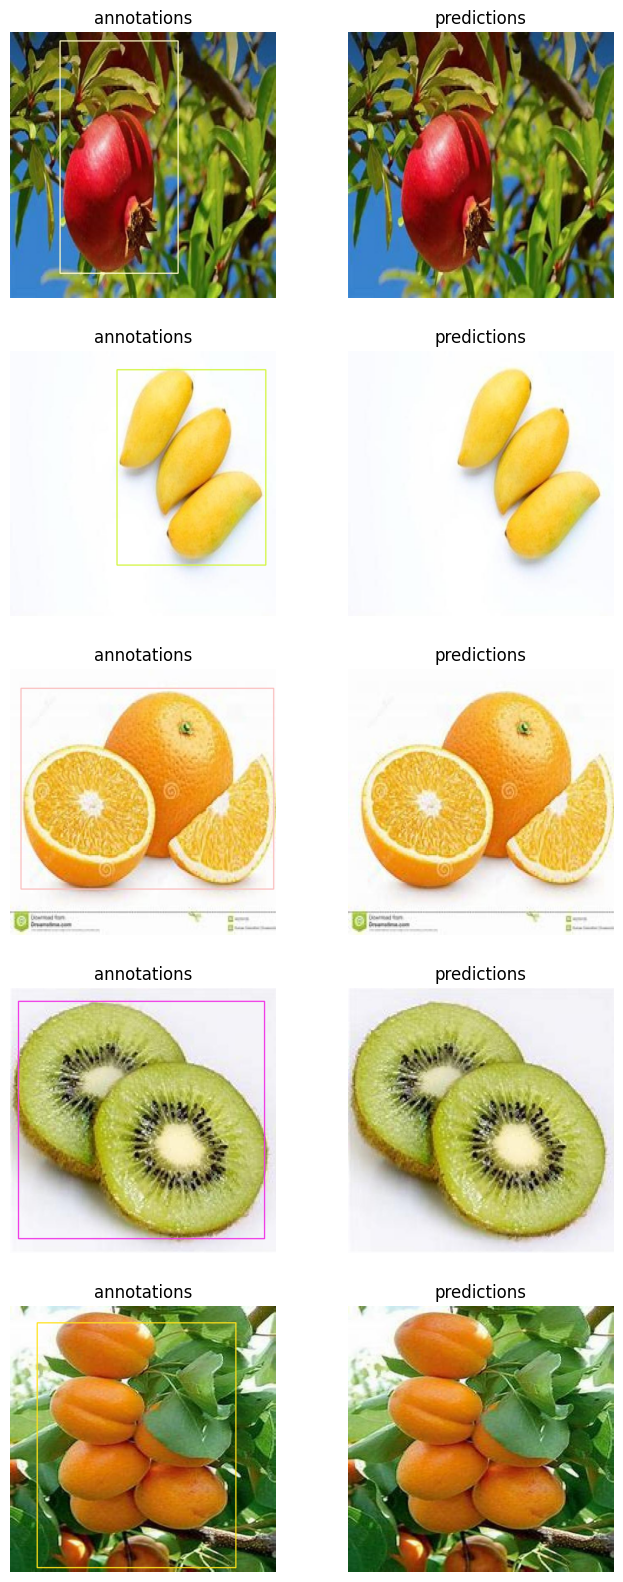

In [ ]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

In [ ]:
pred = model.predict(sample.filepath, conf = 0.9)
print(next(pred._images_prediction_lst))

NameError: ignored

[2023-09-18 23:36:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


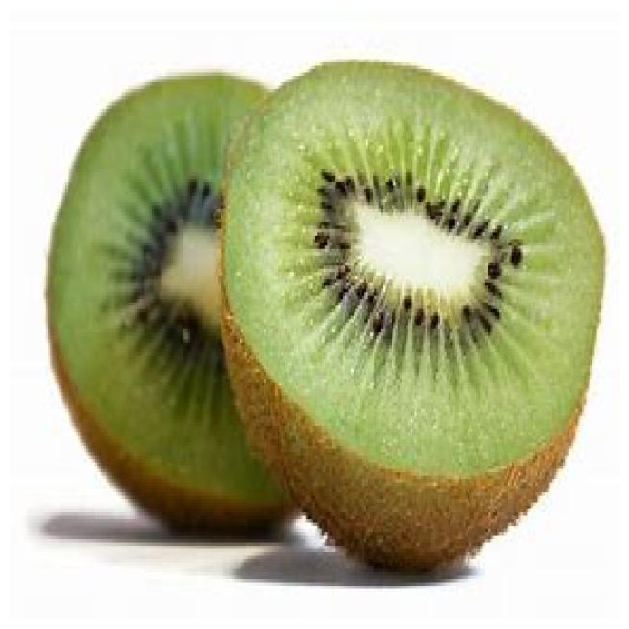

In [ ]:
img_url = '/content/Fruits-15-1/test/images/0-12-_jpg.rf.ccef662d3e9a69bf68e4bef0fd7da681.jpg'
best_model.predict(img_url).show()

In [ ]:
!pip install onemetric

NotImplementedError: ignored